In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [5]:
import sys
sys.path.append("..")

In [8]:
from digitalbeamline.extern.m3gnet._featurizer import featurize_material
from digitalbeamline.extern.m3gnet.m3gnet4xas import GRIDS
from digitalbeamline.extern.lightshow import prepare_dataset, save_dataset
from digitalbeamline.utils import set_plotting_defaults

In [9]:
set_plotting_defaults()

# Load, process and split the data for ML

Note currently we're assuming these are oxide databases. So stuff like `X-O`, where `X` is a transition metal.

In [9]:
ELEMENT = "Cu"

In [33]:
grid = np.linspace(8983, 9124, 200)

In [34]:
data = prepare_dataset(f"data/data_feff/{ELEMENT}", grid, featurize_material, ELEMENT)

Loading structures...


100%|███████████████████████████████████████| 2699/2699 [00:01<00:00, 1725.12it/s]


Loading spectra...


100%|███████████████████████████████████████| 2699/2699 [00:01<00:00, 1969.26it/s]


Interpolating spectra...
Double checking indexes...
Converting to arrays...


100%|█████████████████████████████████████████| 5302/5302 [01:22<00:00, 64.14it/s]


Done


# Plot sanity check

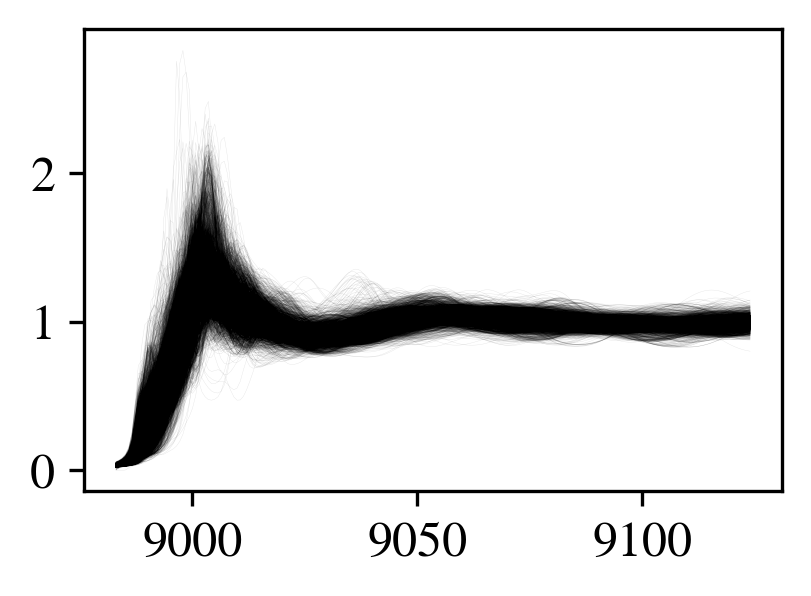

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

for s in data["spectra"]:
    ax.plot(grid, s, color="black", alpha=0.1, linewidth=0.1)
plt.show()

# PCA sanity check

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(1)
w = pca.fit_transform(data["node_features"])

In [28]:
pca_spectra = PCA(2)
w_spectra = pca_spectra.fit_transform(data["spectra"])

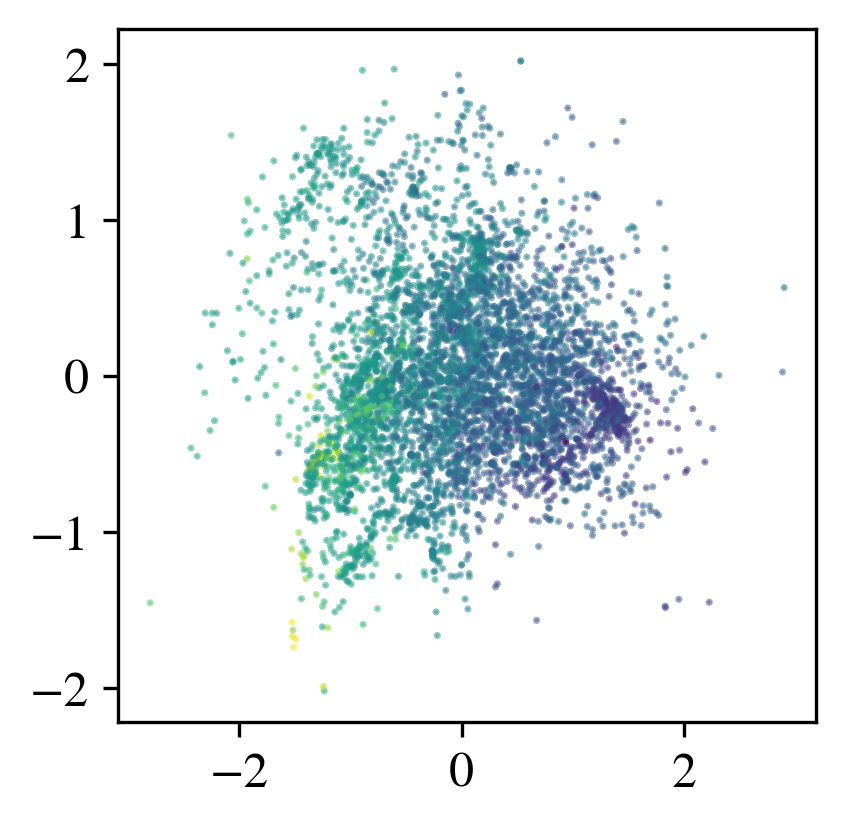

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(w_spectra[:, 0], w_spectra[:, 1], alpha=0.5, s=0.5, c=w)
plt.show()

# Save the data

The `"random"` split method partitions into training, validation and testing splits. Some atoms from a material might be in the training and testing sets, so beware for bias here. We use this as a control regardless.

In [15]:
base_directory = Path(f"{ELEMENT}-O")
base_directory.mkdir(exist_ok=True, parents=True)

In [16]:
random_path = base_directory / "random-splits"
random_path.mkdir(exist_ok=True, parents=True)

In [17]:
save_dataset(random_path, data, train_prop=0.8, split_type="random", random_state=42)

Random split...
Train    X=(4241, 64), Y=(4241, 200)
Val      X=(530, 64), Y=(530, 200)
Test     X=(531, 64), Y=(531, 200)


The `"material"` split method partitions _materials_ into training, validation and testing splits first, then saves the atom-resolved information. This is a less biased way to do the splits, since in reality, we will be training on a set of materials and predicting on completely _new_ materials, not sites. Note that this means the proportions will not be exact (but they'll be close).

In [22]:
materials_path = base_directory / "material-splits"
materials_path.mkdir(exist_ok=True, parents=True)

In [23]:
save_dataset(materials_path, data, train_prop=0.8, split_type="material", random_state=42)

Material split...
Train    X=(4313, 64), Y=(4313, 200)
Val      X=(417, 64), Y=(417, 200)
Test     X=(572, 64), Y=(572, 200)


Save the spectra loading errors (these calculations likely did not converge).

In [24]:
with open(f"{base_directory}/spectra_errors.txt", "w") as f:
    for line in data["spectra_errors"]:
        f.write(f"{line}\n")